# SSA

Use SSA to remove noise and smooth data. This book will contain SSA class and example of SSA at different Window length($L$). Lastly there will be model evaluation below. 
Ref: https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition

#### ** Data cleaning is not included in this notebook **

In [2]:
import pandas as pd
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [4]:
df = pd.read_csv('../DATA/P100254-1 (G43L) CDU-HGO.CSV')

In [5]:
df.head()

,"=""ID""",Name,Sent Time,UT measurement (mm),Temperature (°C),PSI,Apply Temperature Compensation Flag
0,"=""#00096""","=""P100254-1""",2017-05-16 06:24:14,6.298,283.06,NaN,1
1,"=""#00096""","=""P100254-1""",2017-05-16 18:29:47,6.296,283.62,NaN,1
2,"=""#00096""","=""P100254-1""",2017-05-17 06:32:58,6.300,284.41,NaN,1
3,"=""#00096""","=""P100254-1""",2017-05-17 18:36:07,6.303,284.28,NaN,1
4,"=""#00096""","=""P100254-1""",2017-05-18 06:39:23,6.301,284.66,NaN,1


In [6]:
df = df[['UT measurement (mm)']]

In [7]:
F = df.values
N = 892
t = np.arange(0,N)
L = 70
K = N - L + 1 
X = np.column_stack([F[i:i+L] for i in range(0,K)])

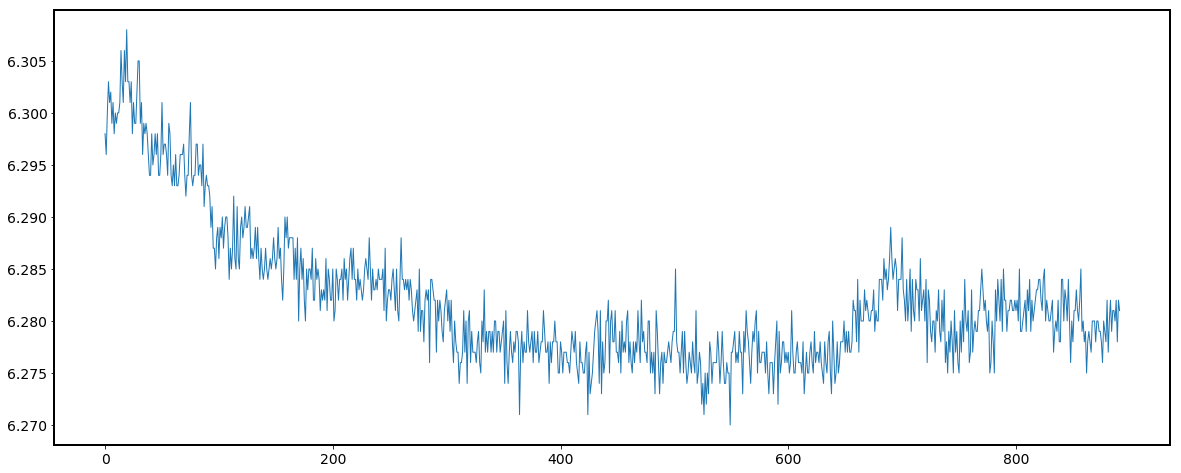

In [7]:
plt.plot(F, lw=1)

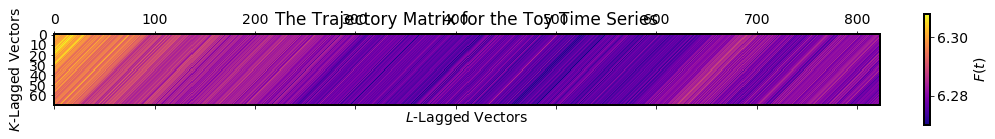

In [8]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Toy Time Series");

In [9]:
d = np.linalg.matrix_rank(X)
U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

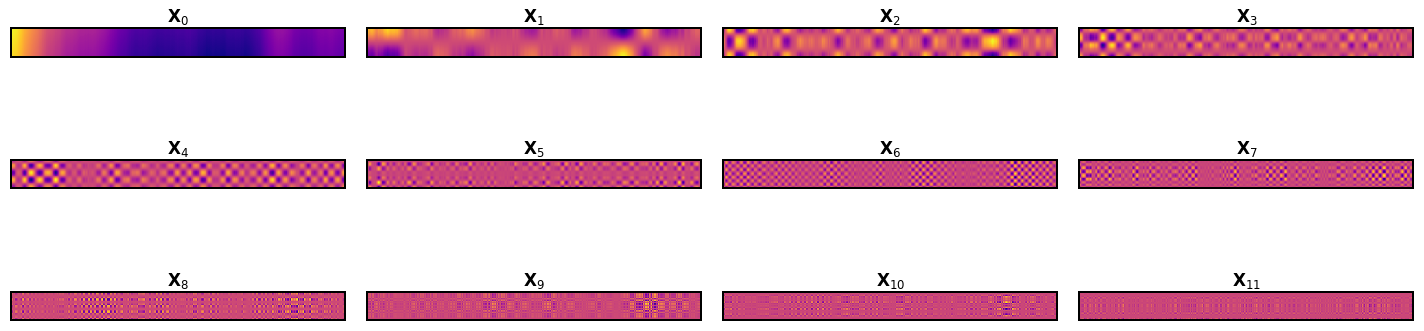

In [10]:
n = min(12, d)
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

In [11]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

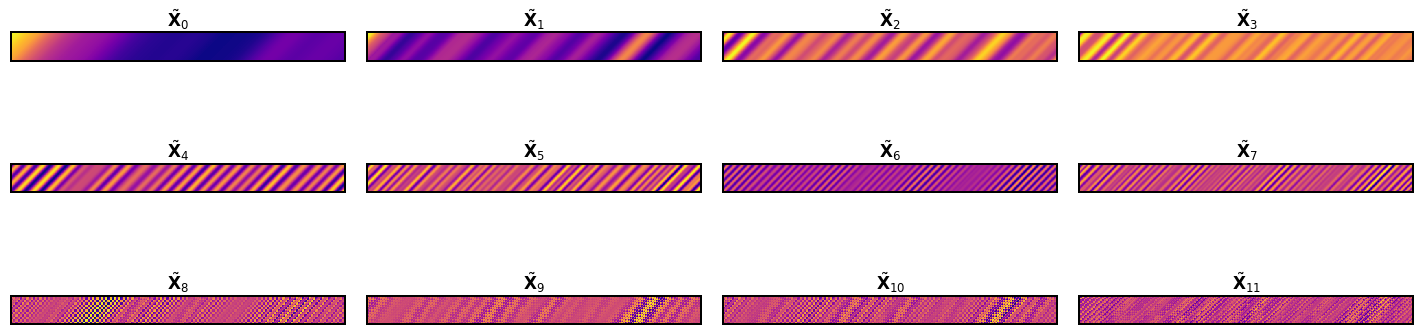

In [12]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

In [13]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

In [14]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

In [15]:
F = df['UT measurement (mm)']

## $L = 2$

In [16]:
F_ssa_L2 = SSA(F, 2)
F_ssa_L2_df = F_ssa_L2.components_to_df()

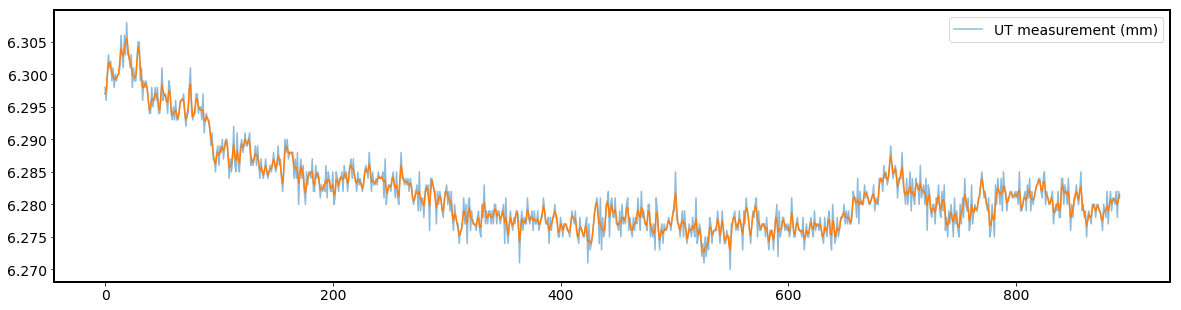

In [17]:
df.plot(alpha=(0.5))
F_ssa_L2_df['F0'].plot(figsize=(20,5));

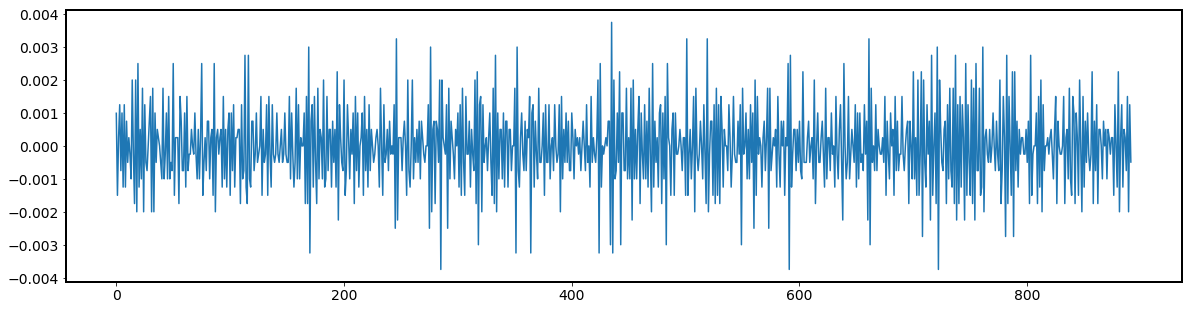

In [18]:
F_ssa_L2_df['F1'].plot(figsize=(20,5));

## $L = 5$

In [19]:
F_ssa_L5 = SSA(F, 5)
F_ssa_L5_df = F_ssa_L5.components_to_df()

In [20]:
F_ssa_L5_df.head()

,F0,F1,F2,F3,F4
0,6.299640,-0.001270,-0.000029,-0.000267,-0.000074
1,6.300031,-0.001490,0.000002,-0.001825,-0.000717
2,6.300354,0.000212,-0.000267,-0.000199,-0.000100
3,6.300561,0.000219,0.000499,0.001045,0.000676
4,6.300480,0.000473,-0.000625,0.000389,0.000283


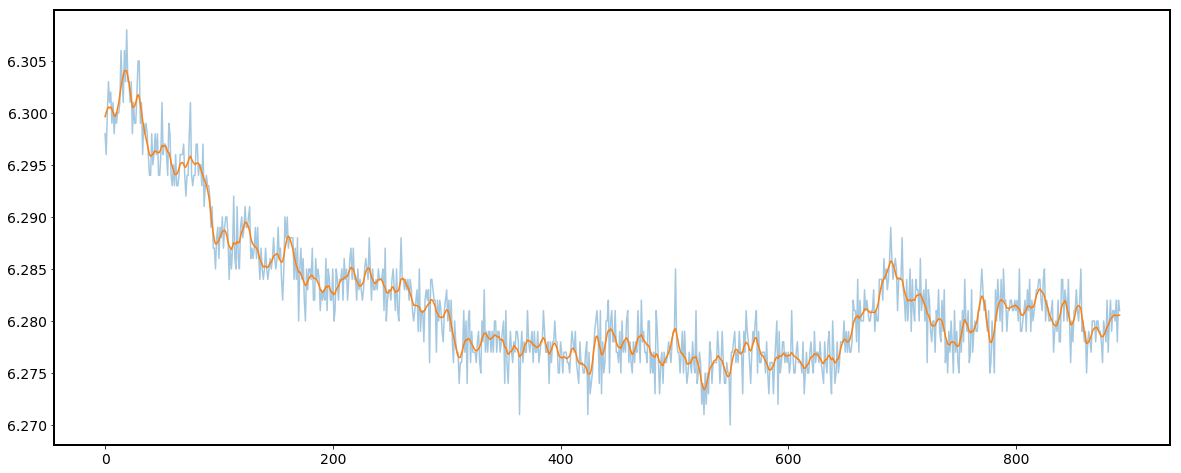

In [21]:
F_ssa_L5.orig_TS.plot(alpha=0.4)
F_ssa_L5.reconstruct(0).plot();

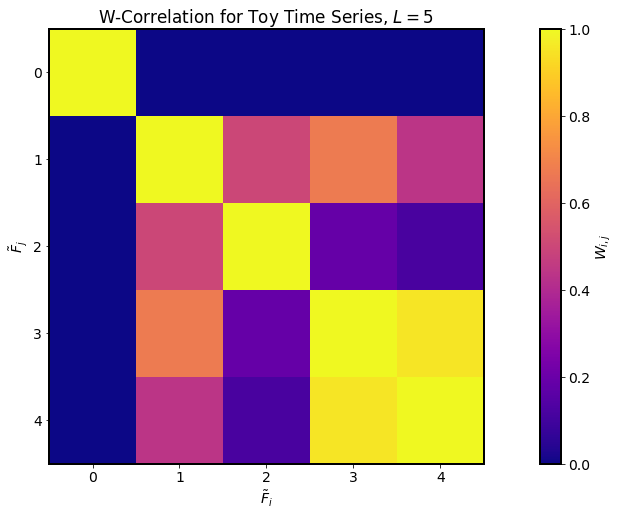

In [22]:
F_ssa_L5.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=5$");

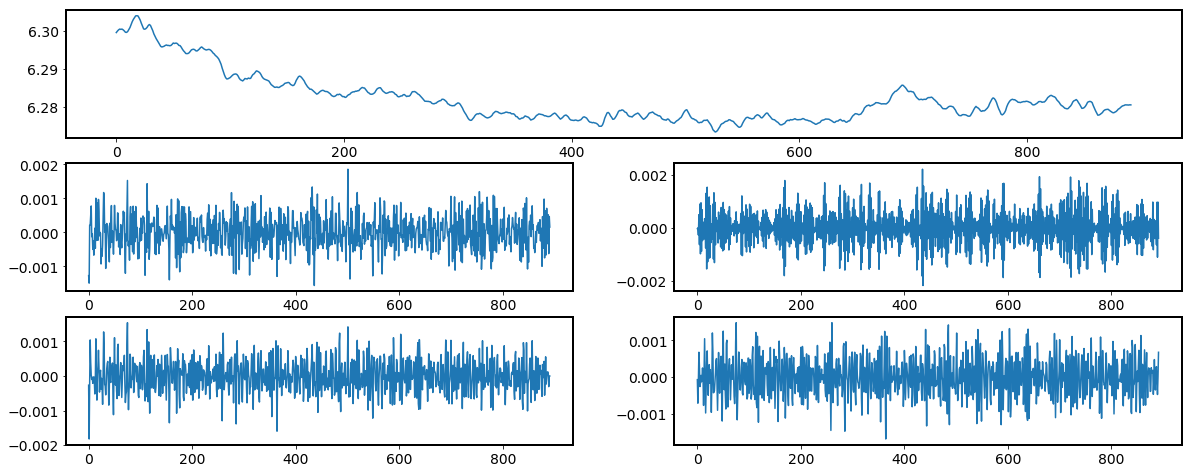

In [23]:
plt.figure(1)
plt.subplot(311)
plt.plot(t,F_ssa_L5_df['F0']);
plt.subplot(323)
plt.plot(t,F_ssa_L5_df['F1']);
plt.subplot(324)
plt.plot(t,F_ssa_L5_df['F2']);
plt.subplot(325)
plt.plot(t,F_ssa_L5_df['F3']);
plt.subplot(326)
plt.plot(t,F_ssa_L5_df['F4']);

In [24]:
F_ssa_L5_df['result'] = F_ssa_L5_df['F0']

## $L = 20$

In [25]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20_df = F_ssa_L20.components_to_df()

In [26]:
F_ssa_L20_df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19
0,6.301478,-0.002564,0.001141,-0.002177,-0.000048,0.000514,0.000021,0.000198,-0.000047,-0.000847,-0.000064,0.000002,-0.000010,-0.000320,0.000506,0.000197,-0.000428,0.000729,-0.000014,-0.000267
1,6.301592,-0.002479,0.001119,-0.000509,0.000275,-0.000614,-0.000083,-0.000230,0.000020,-0.000684,-0.000122,0.000025,-0.000032,-0.000370,-0.000420,-0.000200,-0.000553,-0.000695,-0.000060,0.000018
2,6.301740,-0.002361,0.001090,-0.000205,-0.000685,0.000127,0.000193,0.000222,0.000038,-0.000146,0.000192,-0.000086,0.000017,-0.000162,-0.000226,0.000177,-0.000025,-0.000320,0.000173,0.000246
3,6.301821,-0.002219,0.000880,0.000845,0.000848,0.000031,-0.000265,-0.000296,-0.000026,0.000149,-0.000037,0.000089,-0.000040,0.000013,0.000416,-0.000075,0.000629,0.000266,-0.000009,-0.000021
4,6.301863,-0.002162,0.000522,0.000608,-0.000839,-0.000040,0.000112,0.000164,0.000007,0.000175,0.000037,0.000007,0.000096,0.000070,-0.000218,0.000003,0.000515,0.000570,-0.000224,-0.000266


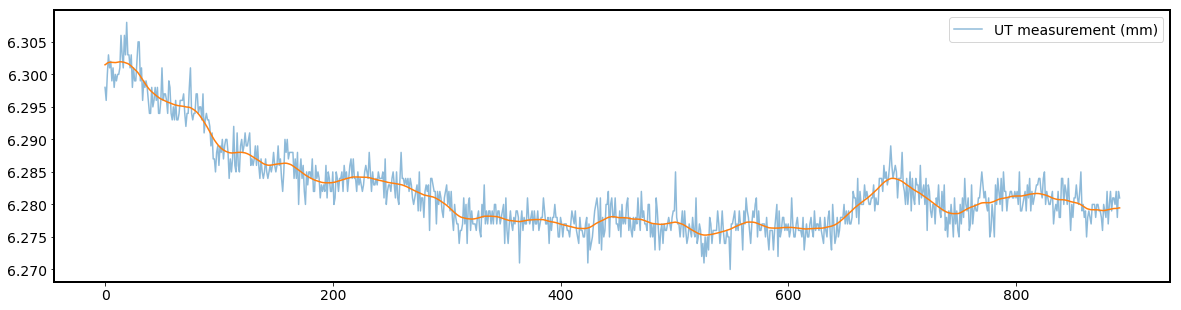

In [27]:
df.plot(alpha=(0.5))
F_ssa_L20_df['F0'].plot(figsize=(20,5));

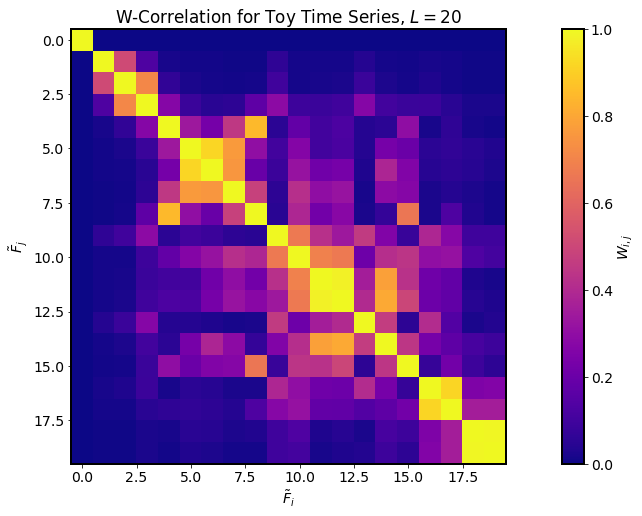

In [28]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=20$");
# F0 = Trend
# F1,..,F3 = Seasonal
# F4,..,F20 = Noise

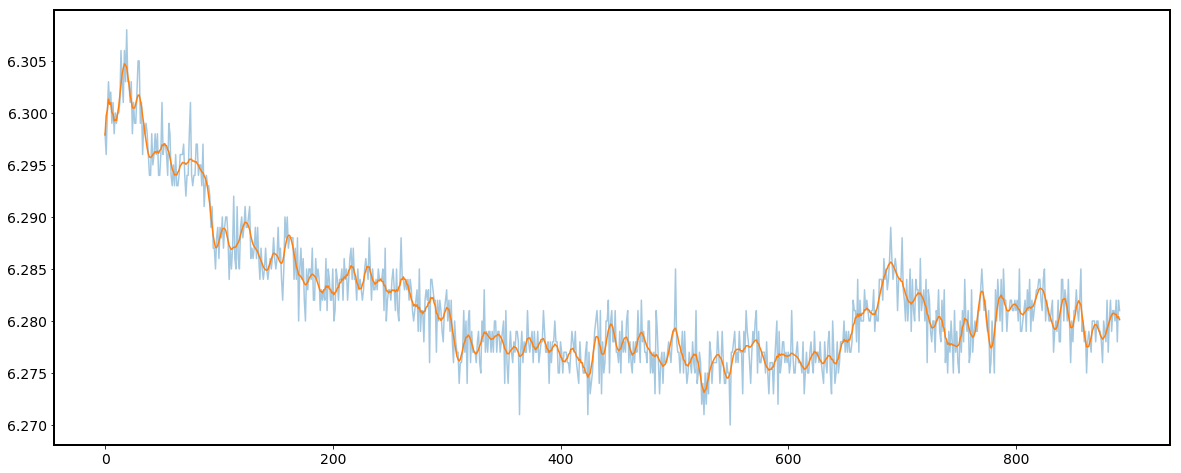

In [29]:
F_ssa_L20.orig_TS.plot(alpha=0.4)
F_ssa_L20.reconstruct([0,1,2,3]).plot();

In [30]:
F_ssa_L20_df['result'] = F_ssa_L20_df['F0']+F_ssa_L20_df['F1']+F_ssa_L20_df['F2']+F_ssa_L20_df['F3']

## $L = 28$

In [31]:
F_ssa_L28 = SSA(F, 28)
F_ssa_L28_df = F_ssa_L28.components_to_df()

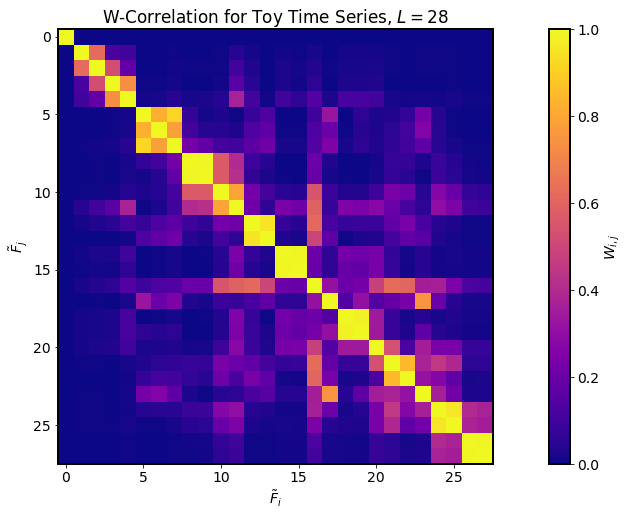

In [32]:
F_ssa_L28.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=28$");
# F0 = Trend
# F1,..,F4 = Seasonal
# F5,..,F25 = Noise

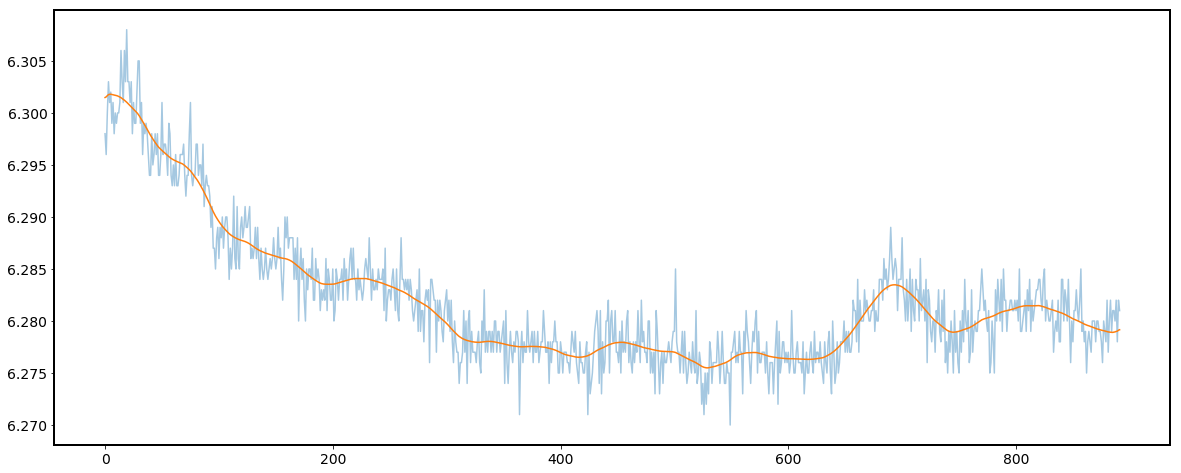

In [34]:
F_ssa_L28.orig_TS.plot(alpha=0.4)
F_ssa_L28.reconstruct([0]).plot();

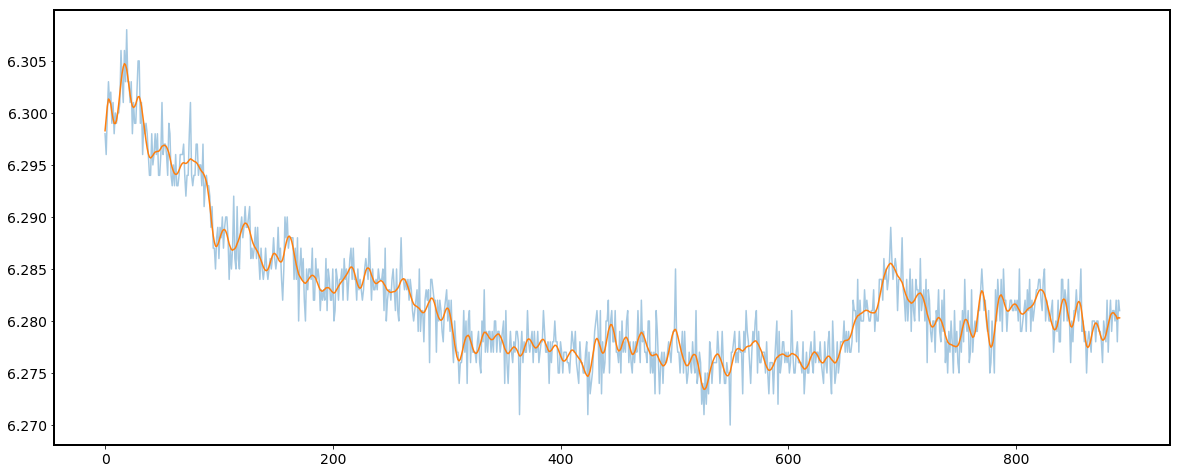

In [35]:
F_ssa_L28.orig_TS.plot(alpha=0.4)
F_ssa_L28.reconstruct([0,1,2,3,4]).plot();

In [36]:
F_ssa_L28_df['result'] = F_ssa_L28_df['F0']+F_ssa_L28_df['F1']+F_ssa_L28_df['F2']+F_ssa_L28_df['F3']+F_ssa_L28_df['F4']

## $L = 40$

In [37]:
F_ssa_L40 = SSA(F, 40)
F_ssa_L40_df = F_ssa_L40.components_to_df()

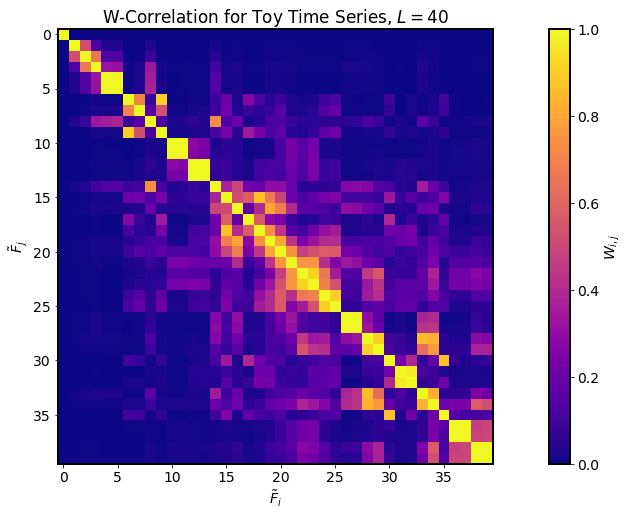

In [38]:
F_ssa_L40.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=40$");
# F0 = Trend
# F1,..,F5 = Seasonal
# F6,..,F40 = Noise

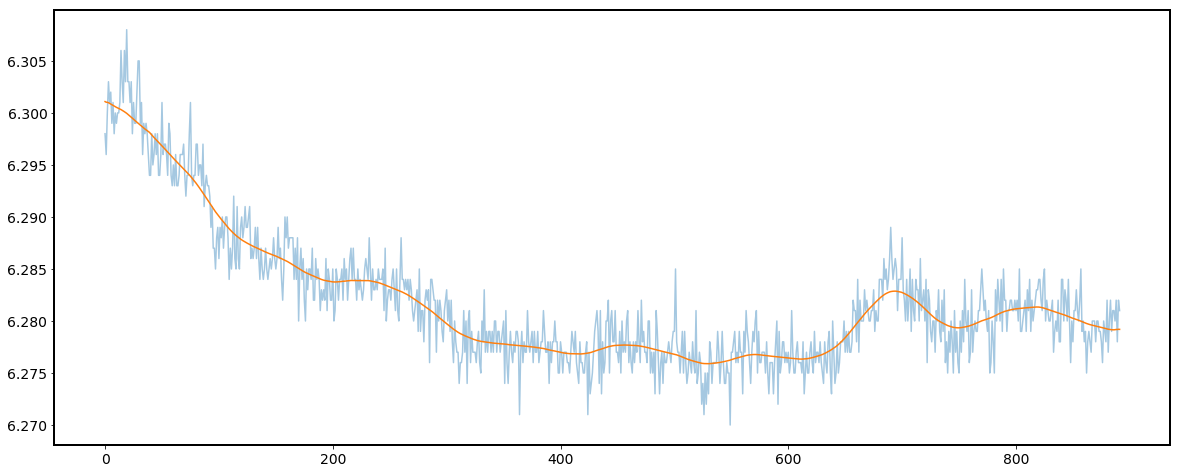

In [56]:
F_ssa_L40.orig_TS.plot(alpha=0.4)
F_ssa_L40.reconstruct([0]).plot();

In [40]:
F_ssa_L40_df['result'] = F_ssa_L40_df['F0']+F_ssa_L40_df['F1']+F_ssa_L40_df['F2']+F_ssa_L40_df['F3']+F_ssa_L40_df['F4']+F_ssa_L40_df['F5']

## L = 100

In [54]:
F_ssa_L100 = SSA(F,100)
F_ssa_L100_df = F_ssa_L100.components_to_df()

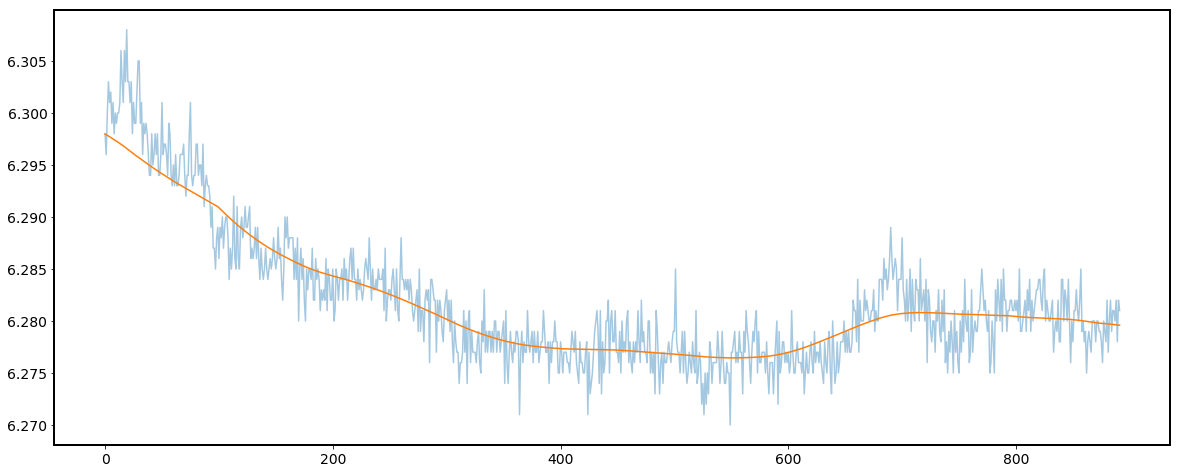

In [55]:
F_ssa_L100.orig_TS.plot(alpha=0.4)
F_ssa_L100.reconstruct([0]).plot();

## Evaluation

In [41]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [42]:
# L=5
mae = mean_absolute_error(df['UT measurement (mm)'],F_ssa_L5_df['result'])
mse = mean_squared_error(df['UT measurement (mm)'],F_ssa_L5_df['result'])
print('L=5')
print('mae = ',mae)
print('mse = ',mse)

L=5
mae =  0.0013533091608487146
mse =  2.8918971882561976e-06


In [43]:
# L=20
mae = mean_absolute_error(df['UT measurement (mm)'],F_ssa_L20_df['result'])
mse = mean_squared_error(df['UT measurement (mm)'],F_ssa_L20_df['result'])
print('L=20')
print('mae = ',mae)
print('mse = ',mse)

L=20
mae =  0.0013592877273843863
mse =  2.9345172004225265e-06


In [44]:
# L=28
mae = mean_absolute_error(df['UT measurement (mm)'],F_ssa_L28_df['result'])
mse = mean_squared_error(df['UT measurement (mm)'],F_ssa_L28_df['result'])
print('L=28')
print('mae = ',mae)
print('mse = ',mse)

L=28
mae =  0.0013937699939223869
mse =  3.0755390710025436e-06


In [45]:
# L=40
mae = mean_absolute_error(df['UT measurement (mm)'],F_ssa_L40_df['result'])
mse = mean_squared_error(df['UT measurement (mm)'],F_ssa_L40_df['result'])
print('L=40')
print('mae = ',mae)
print('mse = ',mse)

L=40
mae =  0.0014318034989130655
mse =  3.2541649476284096e-06


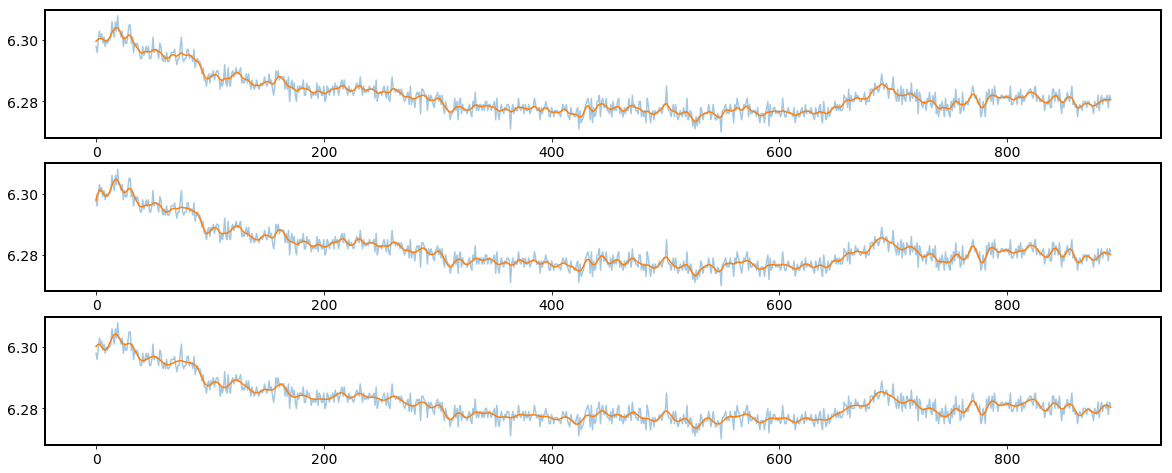

In [46]:
plt.figure(2)
plt.subplot(311)
F_ssa_L5.orig_TS.plot(alpha=0.4)
F_ssa_L5_df['result'].plot()
plt.subplot(312)
F_ssa_L20.orig_TS.plot(alpha=0.4)
F_ssa_L20_df['result'].plot()
plt.subplot(313)
F_ssa_L40.orig_TS.plot(alpha=0.4)
F_ssa_L40_df['result'].plot()

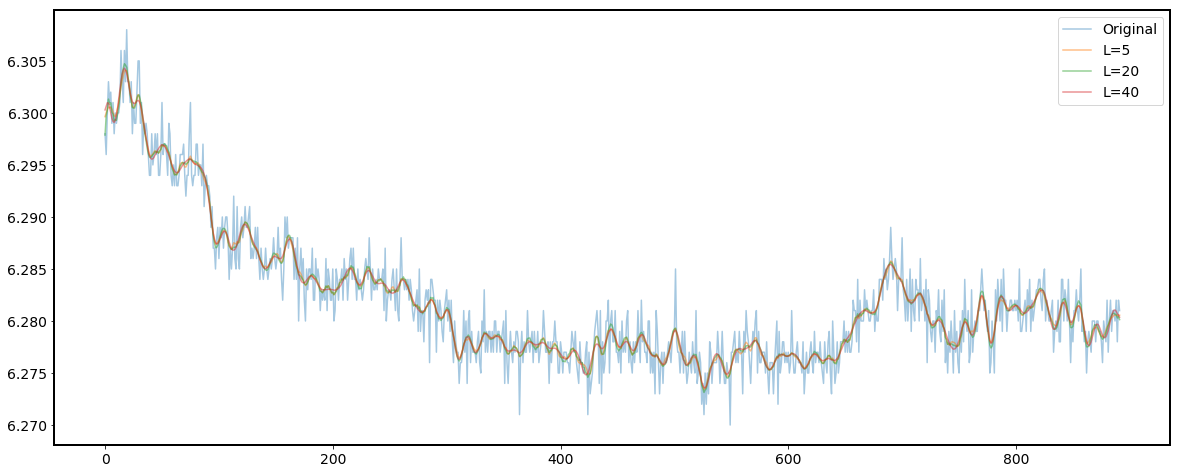

In [47]:
F_ssa_L5.orig_TS.plot(alpha=0.4)
F_ssa_L5_df['result'].plot(alpha=0.5)
F_ssa_L20_df['result'].plot(alpha=0.5)
F_ssa_L40_df['result'].plot(alpha=0.5)
plt.legend(['Original','L=5','L=20','L=40']);